In [144]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import pandas as pd
pd.set_option("display.max_rows", None)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [145]:
print("TensorFlow v" + tf.__version__)
print("TensorFlow Decision Forests v" + tfdf.__version__)

TensorFlow v2.14.1
TensorFlow Decision Forests v1.6.0


In [146]:
train_file_path = "/Users/weizhang/Documents/_GIT/quant-strategies/data/house-prices-advanced-regression-techniques/train.csv"
dataset_df = pd.read_csv(train_file_path)
print("Full train dataset shape is {}".format(dataset_df.shape))

Full train dataset shape is (1460, 81)


In [147]:
dataset_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


Data Cleaning

In [148]:
missing_data = dataset_df.isna().sum()
missing_data = missing_data[missing_data > 0]
missing_data

LotFrontage      259
Alley           1369
MasVnrType       872
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [149]:
lotfrontage_by_neighborhood = dataset_df.groupby("Neighborhood")["LotFrontage"].median()

def impute_lotfrontage(row):
    if pd.isnull(row["LotFrontage"]):
        return lotfrontage_by_neighborhood[row["Neighborhood"]]
    else:
        return row["LotFrontage"]
dataset_df["LotFrontage"] = dataset_df.apply(impute_lotfrontage, axis=1)
dataset_df["LotFrontage"].isnull().sum()

0

In [150]:
most_frequent_electrical = dataset_df["Electrical"].mode()[0]
dataset_df["Electrical"].fillna(most_frequent_electrical, inplace=True)
dataset_df["Electrical"].isnull().sum()

0

In [171]:
categorical_impute_map = {
    'PoolQC': 'N',
    'MiscFeature': 'N',
    'Alley': 'N',
    'Fence': 'N',
    'FireplaceQu': 'N',
    'GarageType': 'N',
    'GarageFinish': 'N',
    'GarageQual': 'N',
    'GarageCond': 'N',
    'BsmtExposure': 'N',
    'BsmtFinType2': 'N',
    'BsmtFinType1': 'N',
    'BsmtCond': 'N',
    'BsmtQual': 'N',
    'MasVnrType': 'N'
}
for col, value in categorical_impute_map.items():
    dataset_df[col].fillna(value, inplace=True)

numerical_impute_map = {
    'GarageYrBlt': 0,
    'MasVnrArea': 0
}

for col, value in numerical_impute_map.items():
    dataset_df[col].fillna(value, inplace=True)

In [172]:
missing_data = dataset_df.isna().sum()
missing_data = missing_data[missing_data > 0]
missing_data

Series([], dtype: int64)

In [173]:
def check_dtypes(df):
    dtypes = []
    for col in df.columns:
        dtypes.append((col, df[col].apply(type).unique()))
    return pd.DataFrame(dtypes, columns=["Column Name", "Data Type"])
check_dtypes(dataset_df)

,Column Name,Data Type
0,MSSubClass,[<class 'int'>]
1,MSZoning,[<class 'str'>]
2,LotFrontage,[<class 'float'>]
3,LotArea,[<class 'int'>]
4,Street,[<class 'str'>]
5,Alley,[<class 'str'>]
6,LotShape,[<class 'str'>]
7,LandContour,[<class 'str'>]
8,Utilities,[<class 'str'>]
9,LotConfig,[<class 'str'>]


In [174]:
numeric_columns = dataset_df.select_dtypes(include=["int64", "float64"]).columns.tolist()
negative_count = dataset_df[numeric_columns].apply(lambda x: (x < 0).sum())
negative_count

MSSubClass       0
LotFrontage      0
LotArea          0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
MasVnrArea       0
BsmtFinSF1       0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
TotRmsAbvGrd     0
Fireplaces       0
GarageYrBlt      0
GarageCars       0
GarageArea       0
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
3SsnPorch        0
ScreenPorch      0
PoolArea         0
MiscVal          0
MoSold           0
YrSold           0
SalePrice        0
dtype: int64

Noise Detecting

In [175]:
allowed_values = {20, 30, 40, 45, 50, 60, 70, 75, 80, 85, 90, 120, 150, 160, 180, 190}
unique_values = dataset_df["MSSubClass"].unique()
unique_values.sort()
unexpected_values = set(unique_values) - allowed_values
unexpected_values

set()

In [176]:
allowed_values = {'A','C','FV','I','RH','RL','RP','RM'}
unique_values = dataset_df["MSZoning"].unique()
unique_values.sort()
unexpected_values = set(unique_values) - allowed_values
unexpected_values

{'C (all)'}

In [177]:
dataset_df["MSZoning"] = dataset_df["MSZoning"].replace("C (all)", "C")
unique_values = dataset_df["MSZoning"].unique()
unique_values.sort()
unexpected_values = set(unique_values) - allowed_values
unique_values

array(['C', 'FV', 'RH', 'RL', 'RM'], dtype=object)

In [151]:
dataset_df = dataset_df.drop("Id", axis=1)
dataset_df.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [152]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1460 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


<Figure size 900x800 with 0 Axes>

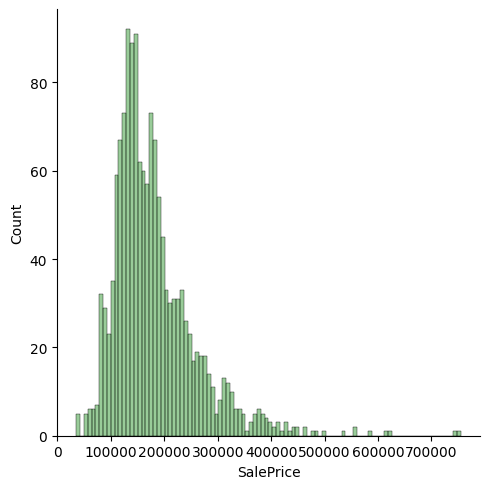

In [153]:
print(dataset_df["SalePrice"].describe())
plt.figure(figsize=(9, 8))
sns.displot(dataset_df["SalePrice"], color="g", bins=100, alpha=0.4)

In [154]:
list(set(dataset_df.dtypes.tolist()))

[dtype('O'), dtype('int64'), dtype('float64')]

In [155]:
df_num = dataset_df.select_dtypes(include = ["float64", "int64"])
df_num.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000


array([[<Axes: title={'center': 'MSSubClass'}>,
        <Axes: title={'center': 'LotFrontage'}>,
        <Axes: title={'center': 'LotArea'}>,
        <Axes: title={'center': 'OverallQual'}>,
        <Axes: title={'center': 'OverallCond'}>,
        <Axes: title={'center': 'YearBuilt'}>],
       [<Axes: title={'center': 'YearRemodAdd'}>,
        <Axes: title={'center': 'MasVnrArea'}>,
        <Axes: title={'center': 'BsmtFinSF1'}>,
        <Axes: title={'center': 'BsmtFinSF2'}>,
        <Axes: title={'center': 'BsmtUnfSF'}>,
        <Axes: title={'center': 'TotalBsmtSF'}>],
       [<Axes: title={'center': '1stFlrSF'}>,
        <Axes: title={'center': '2ndFlrSF'}>,
        <Axes: title={'center': 'LowQualFinSF'}>,
        <Axes: title={'center': 'GrLivArea'}>,
        <Axes: title={'center': 'BsmtFullBath'}>,
        <Axes: title={'center': 'BsmtHalfBath'}>],
       [<Axes: title={'center': 'FullBath'}>,
        <Axes: title={'center': 'HalfBath'}>,
        <Axes: title={'center': 'Bedroo

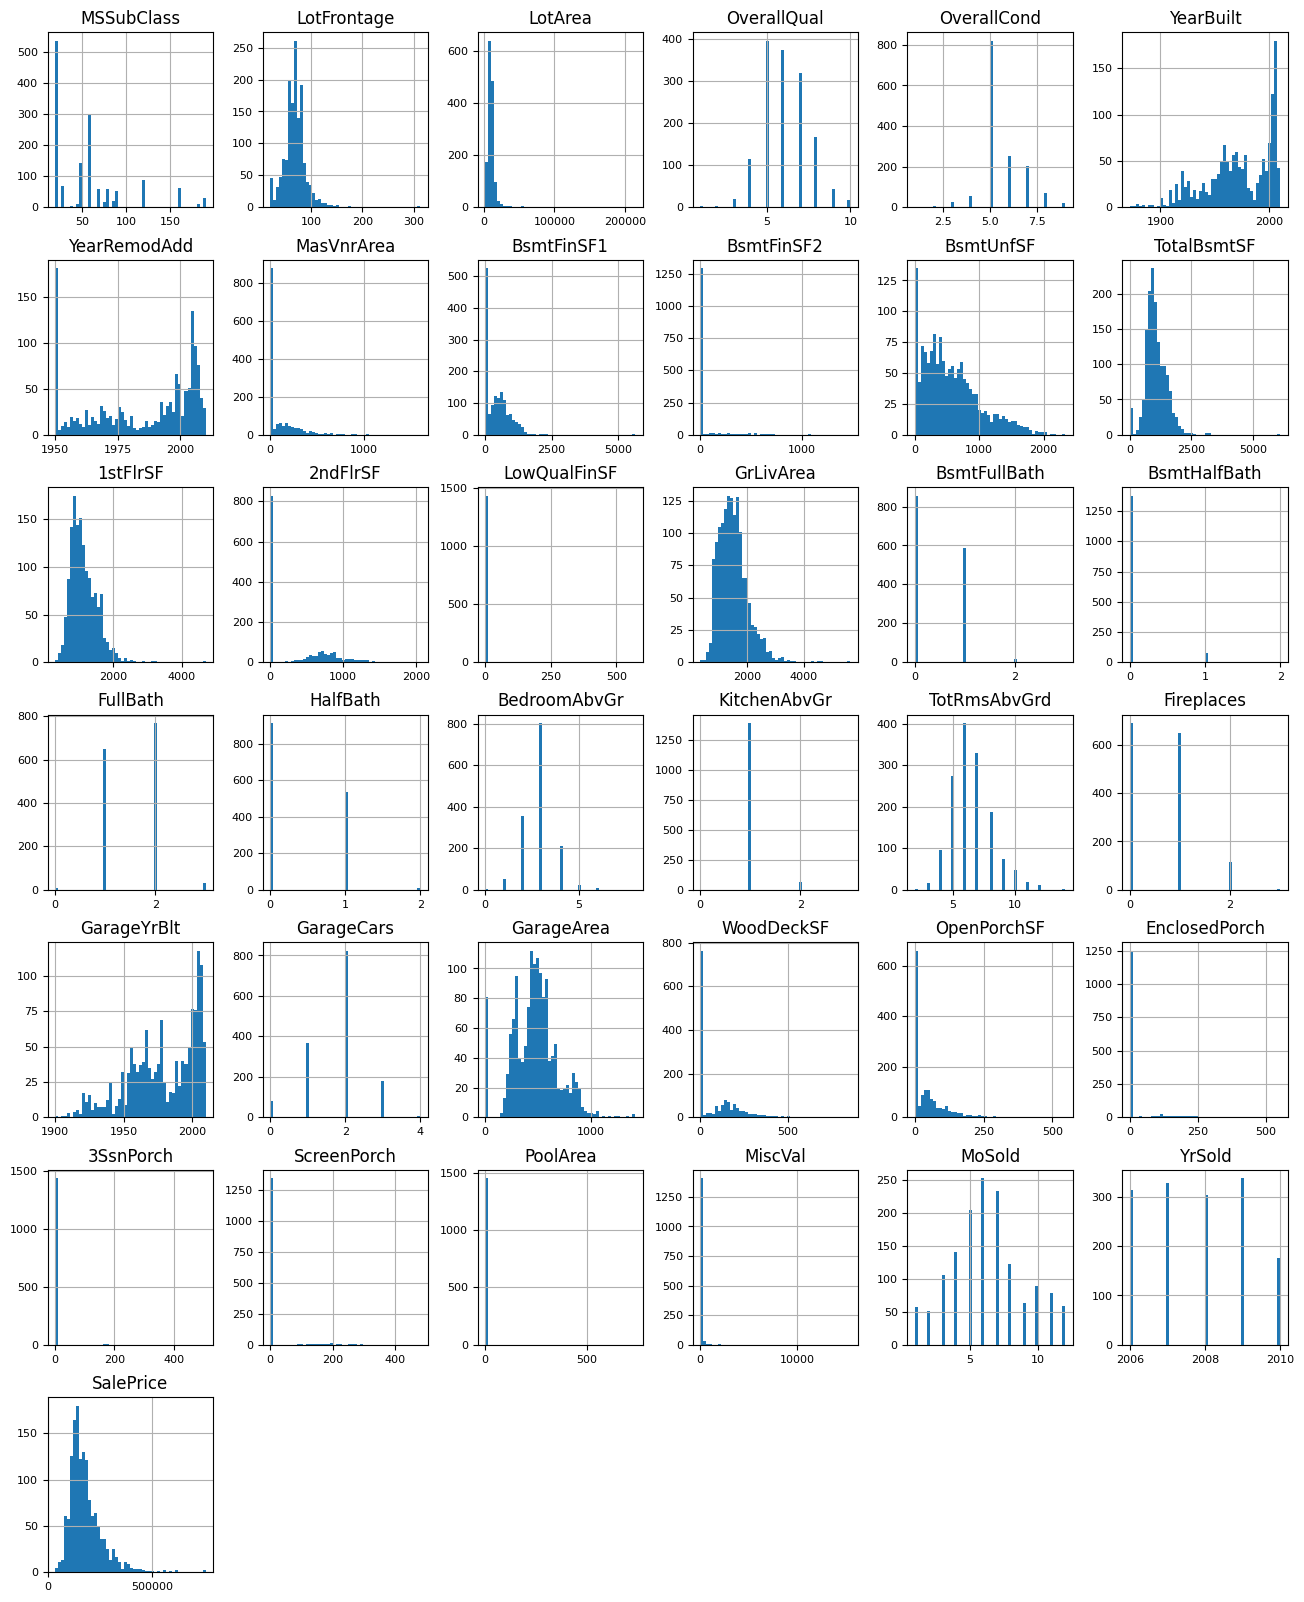

In [156]:
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)

In [157]:


def split_dataset(dataset, test_ratio = 0.3):
    test_indices = np.random.rand(len(dataset)) < test_ratio
    return dataset[~test_indices], dataset[test_indices]

train_ds_pd, valid_ds_pd = split_dataset(dataset_df)
print("{} examples in training, {} examples in testing.".format(len(train_ds_pd), len(valid_ds_pd)))

1005 examples in training, 455 examples in testing.


In [158]:
label = "SalePrice"
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label, task=tfdf.keras.Task.REGRESSION)
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd, label=label, task=tfdf.keras.Task.REGRESSION)

In [159]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

In [160]:
rf = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION)
rf.compile(metrics=["mse"])

Use /var/folders/q4/1pm9hjbn75572h42b6yctkj80000gn/T/tmp29t5dhvb as temporary training directory


In [161]:
rf.fit(x=train_ds)

Reading training dataset...
Training dataset read in 0:00:00.855244. Found 1005 examples.
Training model...


[INFO 23-11-16 14:29:03.6373 EST kernel.cc:1233] Loading model from path /var/folders/q4/1pm9hjbn75572h42b6yctkj80000gn/T/tmp29t5dhvb/model/ with prefix 004c5a8ced1348ac


Model trained in 0:00:01.264601
Compiling model...


[INFO 23-11-16 14:29:03.9252 EST decision_forest.cc:660] Model loaded with 300 root(s), 95476 node(s), and 74 input feature(s).
[INFO 23-11-16 14:29:03.9252 EST abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 23-11-16 14:29:03.9253 EST kernel.cc:1061] Use fast generic engine


Model compiled.


In [162]:
tfdf.model_plotter.plot_model_in_colab(rf, tree_idx=0, max_depth=3)

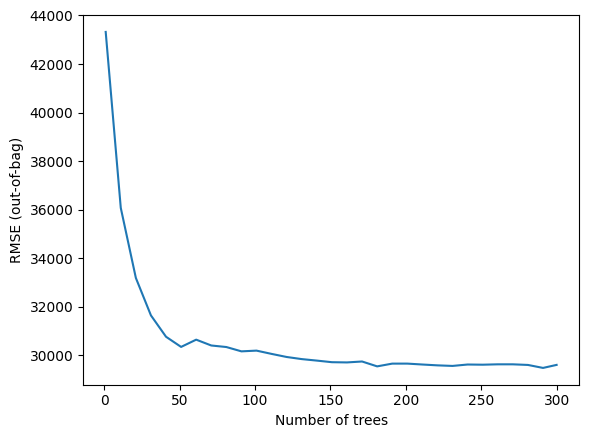

In [163]:
logs = rf.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.show()

In [164]:
inspector = rf.make_inspector()
inspector.evaluation()

Evaluation(num_examples=1005, accuracy=None, loss=None, rmse=29601.66025721517, ndcg=None, aucs=None, auuc=None, qini=None)

In [165]:
evaluation = rf.evaluate(x=valid_ds, return_dict=True)

for name, value in evaluation.items():
    print(f"{name}: {value:.4f}")

1/1 [==============================] - 0s 378ms/step - loss: 0.0000e+00 - mse: 927059264.0000
loss: 0.0000
mse: 927059264.0000


In [166]:
print(f"Available variable importance:")
for importance in inspector.variable_importances().keys():
    print("\t", importance)

Available variable importance:
	 INV_MEAN_MIN_DEPTH
	 SUM_SCORE
	 NUM_AS_ROOT
	 NUM_NODES


In [167]:
inspector.variable_importances()["NUM_AS_ROOT"]

[("OverallQual" (1; #62), 113.0),
 ("ExterQual" (4; #22), 79.0),
 ("Neighborhood" (4; #59), 37.0),
 ("GarageCars" (1; #32), 26.0),
 ("GrLivArea" (1; #38), 13.0),
 ("YearBuilt" (1; #76), 10.0),
 ("BsmtQual" (4; #14), 7.0),
 ("KitchenQual" (4; #44), 6.0),
 ("TotalBsmtSF" (1; #73), 4.0),
 ("GarageArea" (1; #31), 3.0),
 ("1stFlrSF" (1; #0), 1.0),
 ("GarageYrBlt" (1; #37), 1.0)]

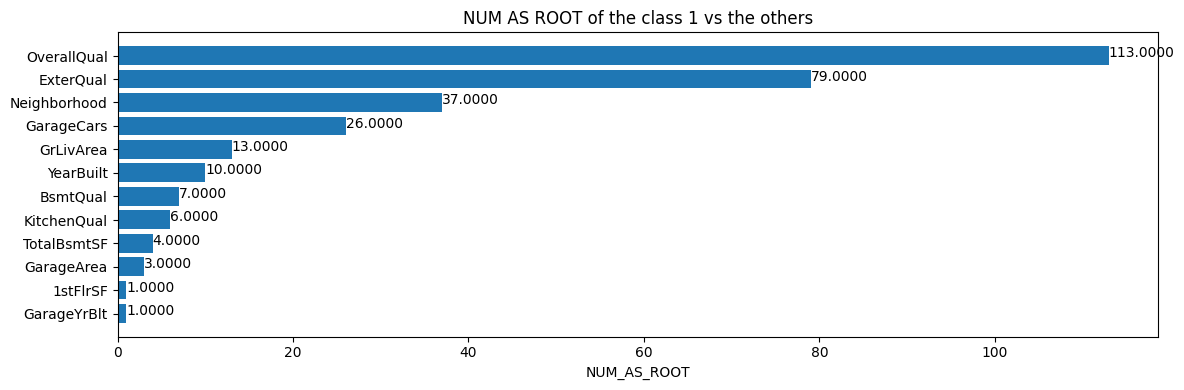

In [168]:
plt.figure(figsize=(12, 4))
variable_importance_metric = "NUM_AS_ROOT"
variable_importances = inspector.variable_importances()[variable_importance_metric]
feature_names = [vi[0].name for vi in variable_importances]
feature_importances = [vi[1] for vi in variable_importances]
feature_ranks = range(len(feature_names))

bar = plt.barh(feature_ranks, feature_importances, label=[str(x) for x in feature_ranks])
plt.yticks(feature_ranks, feature_names)
plt.gca().invert_yaxis()

for importance, patch in zip(feature_importances, bar.patches):
    plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{importance:.4f}", va="top")

plt.xlabel(variable_importance_metric)
plt.title("NUM AS ROOT of the class 1 vs the others")
plt.tight_layout()
plt.show()

In [169]:
test_file_path = "/Users/weizhang/Documents/_GIT/quant-strategies/data/house-prices-advanced-regression-techniques/test.csv"
test_data = pd.read_csv(test_file_path)
ids = test_data.pop("Id")
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_data, task=tfdf.keras.Task.REGRESSION)
preds = rf.predict(test_ds)
output = pd.DataFrame({"Id": ids, "SalePrice": preds.squeeze()})
output.head()

2/2 [==============================] - 1s 18ms/step


,Id,SalePrice
0,1461,124328.273438
1,1462,156760.000000
2,1463,181526.375000
3,1464,187608.625000
4,1465,202762.781250


In [170]:
sample_submission_df = pd.read_csv("/Users/weizhang/Documents/_GIT/quant-strategies/data/house-prices-advanced-regression-techniques/sample_submission.csv")
sample_submission_df["SalePrice"] = rf.predict(test_ds)
sample_submission_df.to_csv("/Users/weizhang/Documents/_GIT/quant-strategies/data/house-prices-advanced-regression-techniques/submission.csv", index=False)
sample_submission_df.head()

2/2 [==============================] - 0s 22ms/step


,Id,SalePrice
0,1461,124328.273438
1,1462,156760.000000
2,1463,181526.375000
3,1464,187608.625000
4,1465,202762.781250
